In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#take a look at the kind of GPU we have
!nvidia-smi

Mon May 23 02:29:43 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   42C    P8    10W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
import sys
sys.path.append("/content/Segmentation-of-Teeth-in-Panoramic-X-ray-Image")

In [ ]:
from download_dataset import *
import os
path = "/content/Data"
if os.path.exists(path+'/DentalPanoramicXrays.zip') == False:
  os.mkdir(path)
  download_dataset(path+'/')

Downloading...
Completed...


In [ ]:
from images_prepare import *
#pre_images(resize_shape,path,include_zip)
X,X_sizes=pre_images((512,512),path,True)

In [ ]:
from masks_prepare import *
#Y=pre_masks(resize_shape=(512,512),path='/content/Segmentation-of-Teeth-in-Panoramic-X-ray-Image/Original_Masks')  ORIGINALL MASKS function 
Y=pre_splitted_masks(path='/content/Segmentation-of-Teeth-in-Panoramic-X-ray-Image/Custom_Masks') #Custom Splitted MASKS size 512x512


In [ ]:
X=np.float32(X/255)
Y=np.float32(Y/255)

In [ ]:
x_train=X[:105,:,:,:]
y_train=Y[:105,:,:,:]
x_test=X[105:,:,:,:]
y_test=Y[105:,:,:,:]

In [ ]:
!pip install -U git+https://github.com/albu/albumentations --no-cache-dir


  Cloning https://github.com/albu/albumentations to /tmp/pip-req-build-b9xxy6qh
  Running command git clone -q https://github.com/albu/albumentations /tmp/pip-req-build-b9xxy6qh
     |████████████████████████████████| 47.8 MB 1.5 MB/s 
  Created wheel for albumentations: filename=albumentations-1.1.0-py3-none-any.whl size=112723 sha256=cff4ec00e30125010b9c74cdf6d2d9c0fdf1609e208a14b44c8580ba0d38ca75
  Stored in directory: /tmp/pip-ephem-wheel-cache-_02g950h/wheels/63/11/1a/c77caf3ae9b9b6d57b3ee5e6a41a50f3bc12c66a70f6b90bf0
Successfully built albumentations
  Attempting uninstall: albumentations
    Found existing installation: albumentations 0.1.12
    Uninstalling albumentations-0.1.12:
      Successfully uninstalled albumentations-0.1.12


In [ ]:
!pip uninstall opencv-python-headless==4.5.5.62

Found existing installation: opencv-python-headless 4.5.5.64
Uninstalling opencv-python-headless-4.5.5.64:
  Would remove:
    /usr/local/lib/python3.7/dist-packages/cv2/*
    /usr/local/lib/python3.7/dist-packages/opencv_python_headless-4.5.5.64.dist-info/*
    /usr/local/lib/python3.7/dist-packages/opencv_python_headless.libs/libavcodec-65fa80df.so.58.134.100
    /usr/local/lib/python3.7/dist-packages/opencv_python_headless.libs/libavformat-8ef5c7db.so.58.76.100
    /usr/local/lib/python3.7/dist-packages/opencv_python_headless.libs/libavutil-9c768859.so.56.70.100
    /usr/local/lib/python3.7/dist-packages/opencv_python_headless.libs/libbz2-a273e504.so.1.0.6
    /usr/local/lib/python3.7/dist-packages/opencv_python_headless.libs/libcrypto-09fe7800.so.1.1
    /usr/local/lib/python3.7/dist-packages/opencv_python_headless.libs/libgfortran-91cc3cb1.so.3.0.0
    /usr/local/lib/python3.7/dist-packages/opencv_python_headless.libs/libopenblas-r0-f650aae0.3.3.so
    /usr/local/lib/python3.7/dis

In [ ]:
!pip install opencv-python-headless==4.5.2.52

     |████████████████████████████████| 38.2 MB 105 kB/s 


In [ ]:
import cv2

import albumentations as A
#Augmention . Change what you want ! Care about Your GPU and CPU RAM

#If you get error : cannot import name '_registerMatType' from 'cv2.cv2' :
#!pip uninstall opencv-python-headless==4.5.5.62
#!pip install opencv-python-headless==4.5.2.52

aug = A.Compose([
    A.OneOf([A.RandomCrop(width=512, height=512),
                 A.PadIfNeeded(min_height=512, min_width=512, p=0.5)],p=0.4),
    A.RandomBrightnessContrast(brightness_limit=0.25, contrast_limit=0.25,p=0.5),
    A.Compose([A.RandomScale(scale_limit=(-0.15, 0.15), p=1, interpolation=1),
                            A.PadIfNeeded(512, 512, border_mode=cv2.BORDER_CONSTANT), 
                            A.Resize(512, 512, cv2.INTER_NEAREST), ],p=0.5),
    A.ShiftScaleRotate (shift_limit=0.325, scale_limit=0.15, rotate_limit=15,border_mode=cv2.BORDER_CONSTANT, p=1),
    A.Rotate(15,p=0.5),
    A.Blur(blur_limit=1, p=0.5),
    A.Downscale(scale_min=0.15, scale_max=0.25,  always_apply=False, p=0.5),
    A.GaussNoise(var_limit=(0.05, 0.1), mean=0, per_channel=True, always_apply=False, p=0.5),
    A.HorizontalFlip(p=0.25),
])

x_train1=np.copy(x_train)
y_train1=np.copy(y_train)
count=0
while(count<4):
  x_aug2=np.copy(x_train1)
  y_aug2=np.copy(y_train1)
  for i in range(len(x_train1)):
    augmented=aug(image=x_train1[i,:,:,:],mask=y_train1[i,:,:,:])
    x_aug2[i,:,:,:]= augmented['image']
    y_aug2[i,:,:,:]= augmented['mask']
  x_train=np.concatenate((x_train,x_aug2))
  y_train=np.concatenate((y_train,y_aug2))
  if count == 9:
    break
  count += 1

In [ ]:
#For Relase unneccasery memory
del x_aug2
del X
del Y
del y_aug2
del y_train1
del x_train1
del augmented

In [ ]:
import random
import matplotlib.pyplot as plt
random_number=random.randint(0,104)
print(random_number)

27


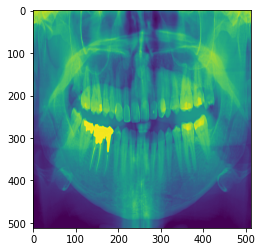

In [ ]:
#Checking data X  and Y matching
plt.imshow(x_train[random_number,:,:,0])

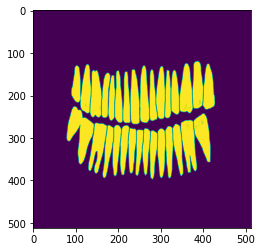

In [ ]:
#Checking data X  and Y matching
plt.imshow(y_train[random_number,:,:,0])

In [ ]:
from model import *
model=UNET(input_shape=(512,512,1),last_activation='sigmoid')
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 512, 512, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 512, 512, 32  320         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 dropout (Dropout)              (None, 512, 512, 32  0           ['conv2d[0][0]']                 
                                )                                                             

In [ ]:
model.compile(optimizer ='adam', loss = 'binary_crossentropy', metrics = ['accuracy'])
#Your choice batch and epoch 
model.fit(x_train,y_train,batch_size=8,epochs=100,verbose=1)

Epoch 1/100
66/66 [==============================] - 100s 1s/step - loss: 0.3583 - accuracy: 0.7891
Epoch 2/100
66/66 [==============================] - 69s 1s/step - loss: 0.2237 - accuracy: 0.8583
Epoch 3/100
66/66 [==============================] - 70s 1s/step - loss: 0.1981 - accuracy: 0.8674
Epoch 4/100
66/66 [==============================] - 70s 1s/step - loss: 0.1762 - accuracy: 0.8761
Epoch 5/100
66/66 [==============================] - 70s 1s/step - loss: 0.1655 - accuracy: 0.8804
Epoch 6/100
66/66 [==============================] - 70s 1s/step - loss: 0.1589 - accuracy: 0.8823
Epoch 7/100
66/66 [==============================] - 70s 1s/step - loss: 0.1522 - accuracy: 0.8852
Epoch 8/100
66/66 [==============================] - 70s 1s/step - loss: 0.1507 - accuracy: 0.8858
Epoch 9/100
66/66 [==============================] - 70s 1s/step - loss: 0.1414 - accuracy: 0.8898
Epoch 10/100
66/66 [==============================] - 70s 1s/step - loss: 0.1397 - accuracy: 0.8903
Epoch 11

In [ ]:
predict_img=model.predict(x_test)
##model.save(path)
predict=predict_img[1,:,:,0] 

In [ ]:
#Example Test
from sklearn.metrics import f1_score
import numpy as np
predict_img1=(predict_img>0.25)*1
y_test1=(y_test>0.25)*1

f1_score(predict_img1.flatten(), y_test1.flatten(), average='micro')

0.9560865922407671

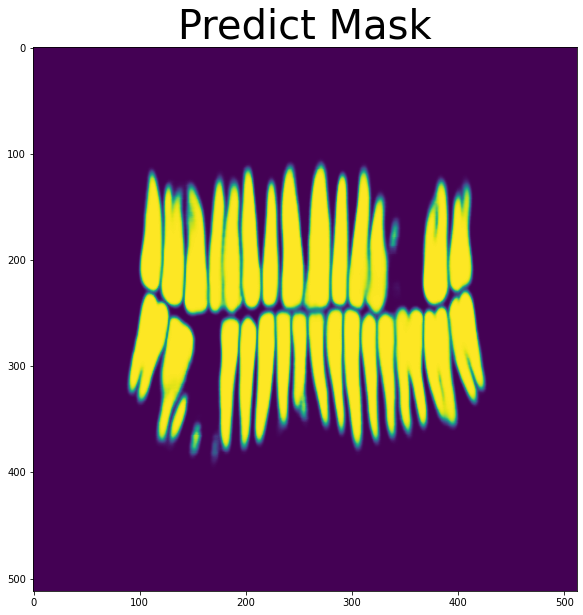

In [ ]:

plt.figure(figsize = (20,10))
plt.title("Predict Mask",fontsize = 40)
plt.imshow(predict)
#For CCA, we saved
plt.imsave("/content/predict.png",predict)

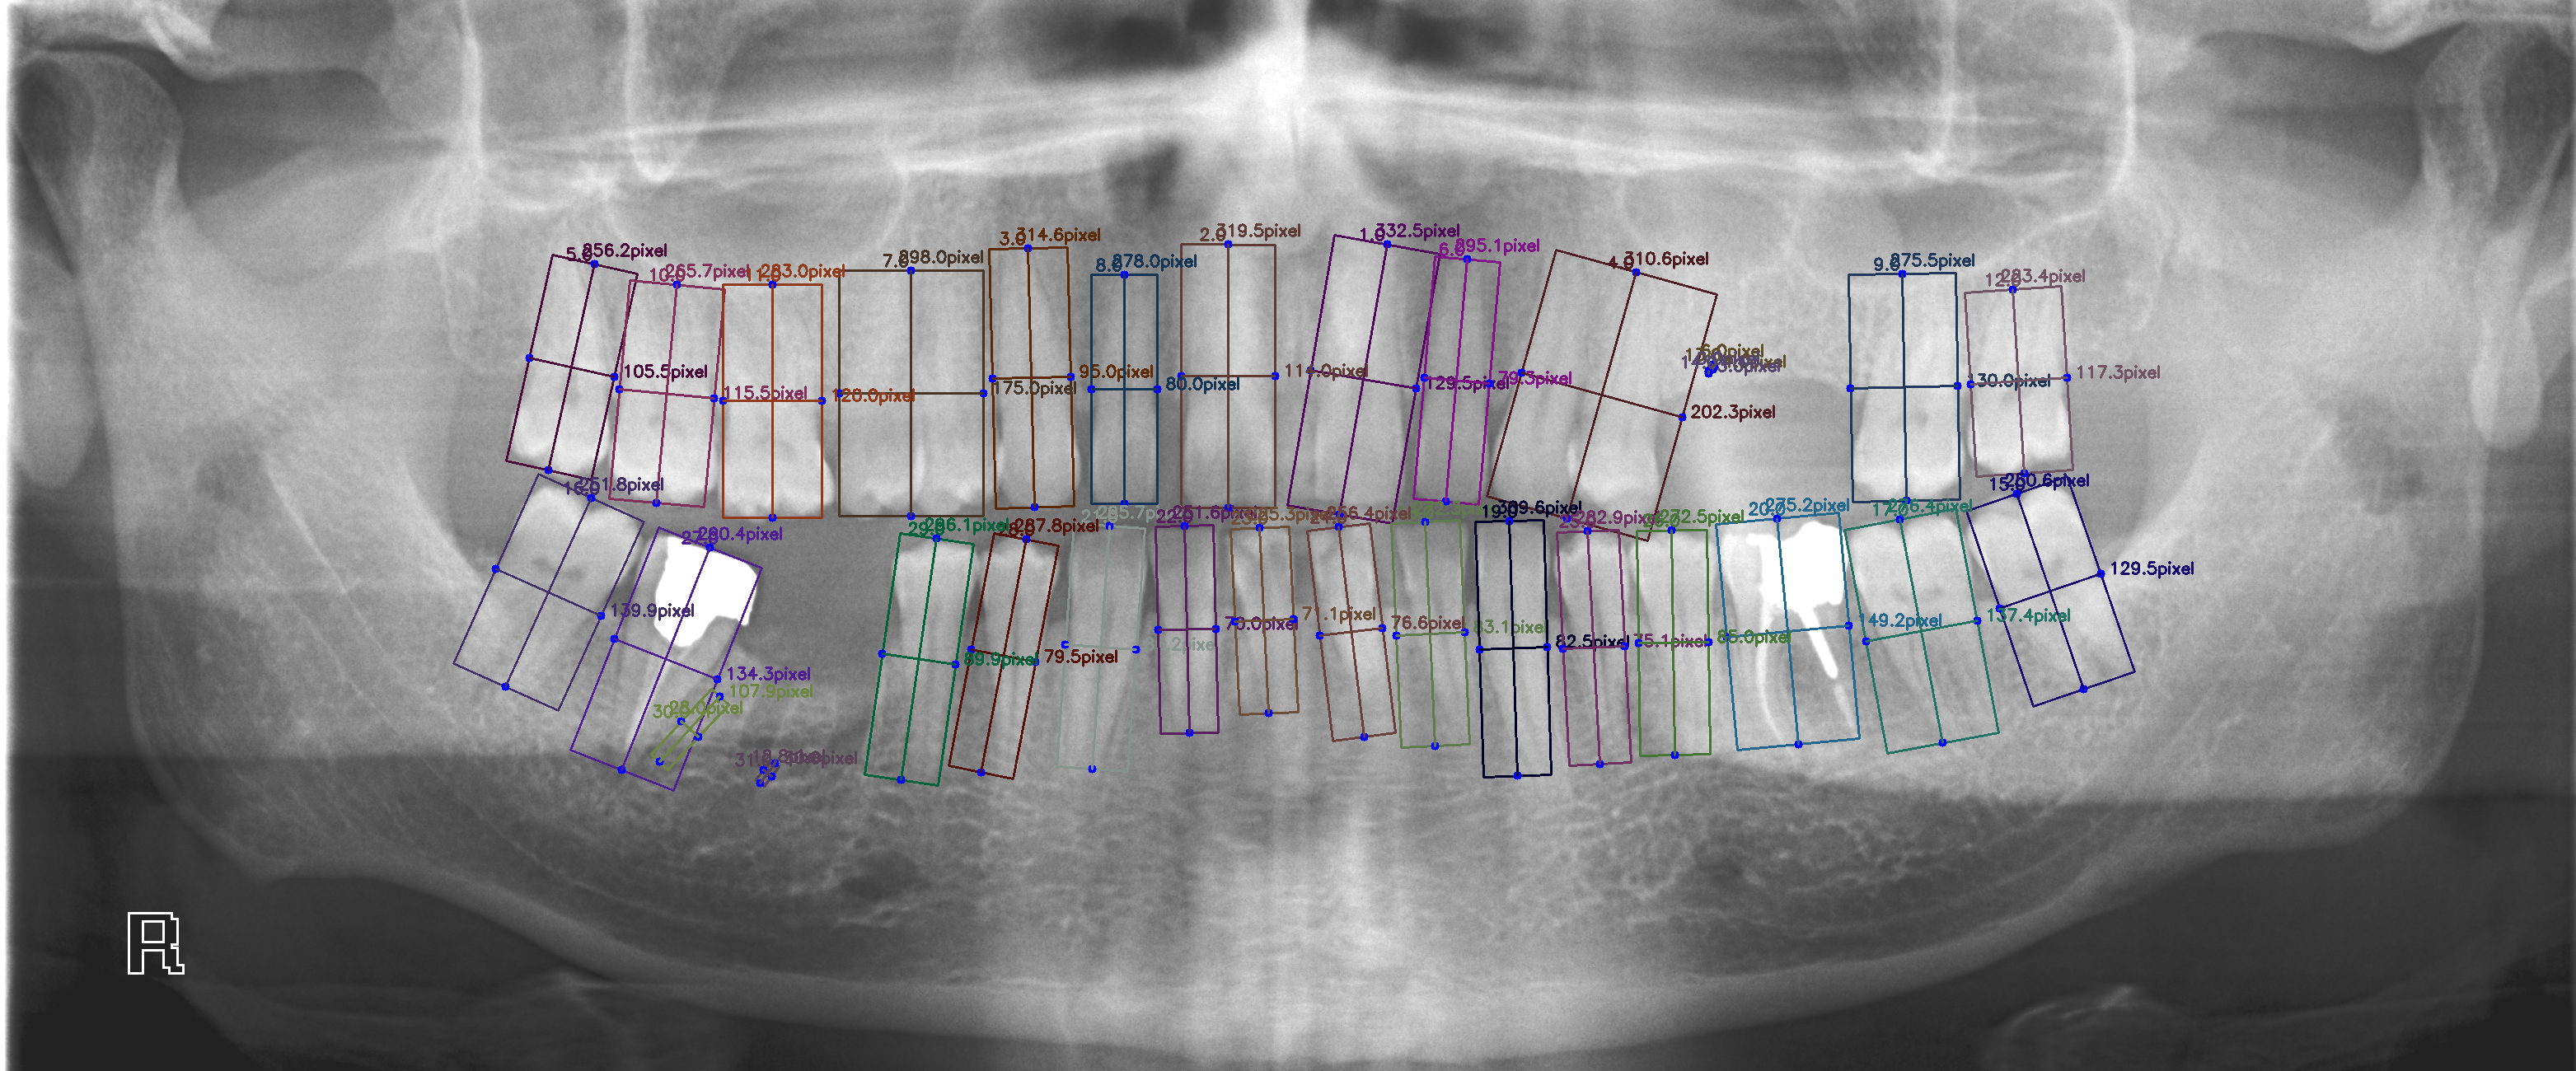

In [ ]:
from google.colab.patches import cv2_imshow
import cv2
from CCA_Analysis import *


##Plotting - RESULT Example with CCA_Analysis
img=cv2.imread("/content/Data/Images/107.png")#original img 107.png 

#load image (mask was saved by matplotlib.pyplot) 
predicted=cv2.imread("/content/predict.png")

predicted = cv2.resize(predicted, (img.shape[1],img.shape[0]), interpolation=cv2.INTER_LANCZOS4)

cca_result,teeth_count=CCA_Analysis(img,predicted,3,2)
cv2_imshow(cca_result)

In [ ]:
print(teeth_count,"Teeth Count")

28 Teeth Count


In [ ]:
import tensorflow as tf
tf.keras.models.save_model(model, '/content/drive/MyDrive/dental_xray_seg.h5')

In [ ]:
from numpy.random import seed
from scipy.stats import mannwhitneyu
import numpy as np
import pandas as pd
import os
seed(1)
#d = os.path.dirname(os.getcwd())

data0 =np.loadtxt("/content/normal.txt")
data1 =np.loadtxt("/content/non_process.txt")
data2 = np.loadtxt("/content/post_processli.txt")
df=pd.read_excel("/content/dsc.xlsx")
e1=np.asarray(df["E1"])
e1=np.reshape(e1,(10,1))
e2=np.asarray(df["E2"])
e2=np.reshape(e2,(10,1))
e3=np.asarray(df["E3"])
e3=np.reshape(e3,(10,1))
e4=np.asarray(df["E4"])
e4=np.reshape(e4,(10,1))
e5=np.asarray(df["E5"])
e5=np.reshape(e5,(10,1))
import numpy as np



error1=np.zeros([len(data1)])
error2=np.zeros([len(data1)])

for i in range(len(data1)):
    error1[i]=np.abs(data1[i]-data0[i])/data0[i]
    error2[i]=np.abs(data2[i]-data0[i])/data0[i]
print("Tooth Count Error")

print("Non-Process Error :",np.sum(error1)/len(error1))
print("Post-Process Error :",np.sum(error2)/len(error2))

Tooth Count Error
Non-Process Error : 0.26814800814384904
Post-Process Error : 0.06151955361850692
